# Credit Card Fraud Detection

Using a dataset of of nearly 28,500 credit card transactions and multiple unsupervised anomaly detection algorithms, we are going to identify transactions with a high probability of being credit card fraud.  In this project, we will build and deploy the following two machine learning algorithms:

Local Outlier Factor (LOF)

Isolation Forest Algorithm

## 1. Importing Necessary Libraries

In [56]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. The Data Set

We will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset.

In [47]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('creditcard.csv')

In [48]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [49]:
# Print the shape of the data
data = data.sample(frac=0.25, random_state = 10)
print(data.shape)
print(data.describe())
# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(71202, 31)
                Time            V1            V2            V3            V4  \
count   71202.000000  71202.000000  71202.000000  71202.000000  71202.000000   
mean    94697.483750     -0.022834      0.002073      0.005963     -0.006223   
std     47542.890523      1.966959      1.651104      1.504403      1.418099   
min         0.000000    -41.928738    -60.464618    -28.407424     -5.519697   
25%     54144.750000     -0.936221     -0.596285     -0.890318     -0.855800   
50%     84618.000000     -0.014450      0.070317      0.183824     -0.030377   
75%    139244.250000      1.306399      0.811111      1.031293      0.743435   
max    172783.000000      2.430507     15.365804      4.226108     16.875344   

                 V5            V6            V7            V8            V9  \
count  71202.000000  71202.000000  71202.000000  71202.000000  71202.000000   
mean      -0.001497     -0.003738      0.003927     -0.004682     -0.002818   
std        1.370439      1.323

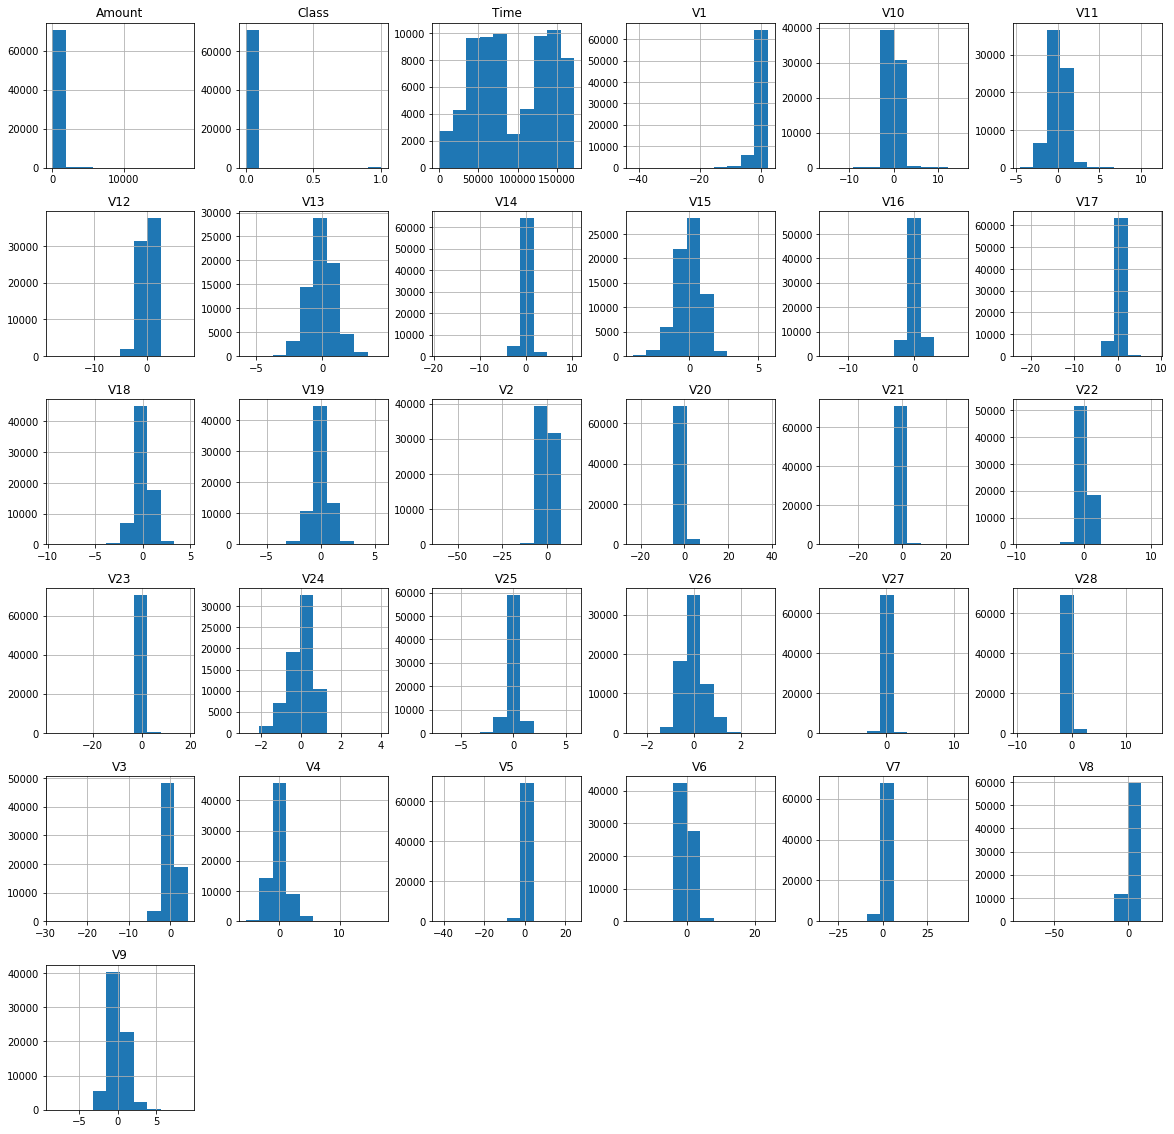

In [50]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

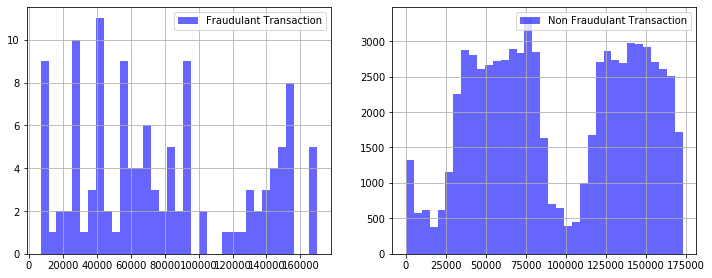

In [58]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

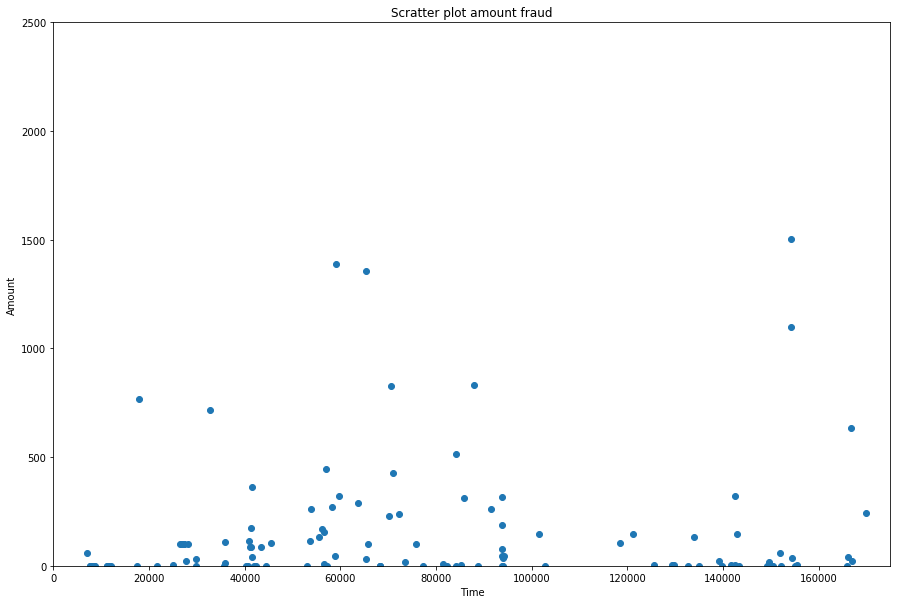

In [59]:
df_fraud = data[data['Class'] == 1] # Recovery of fraud data
plt.figure(figsize=(15,10))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Scratter plot amount fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

We notice,  the time doesn't impact the frequency of frauds. Moreover, the majority of frauds are small amounts.

In [51]:
# Determine number of fraud cases in dataset
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017022833105893277
Fraud Cases: 121
Valid Transactions: 71081


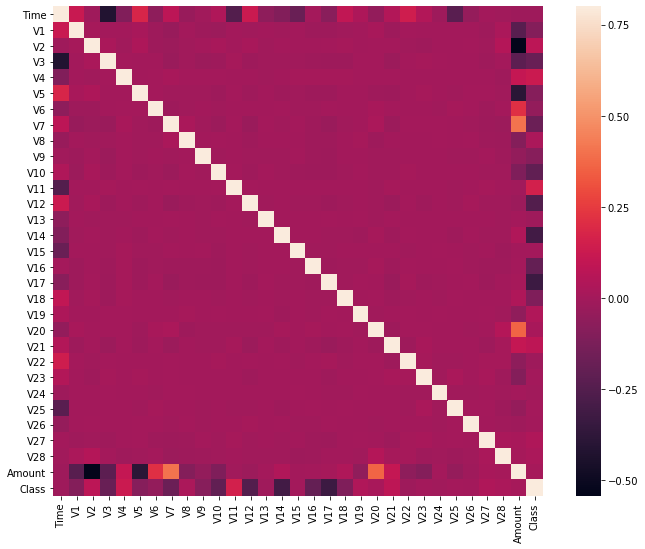

In [52]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [60]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we'll be predicting on
target = "Class"
X = data[columns]
Y = data[target]   
# Print shapes
print(X.shape)
print(Y.shape)

(71202, 30)
(71202,)


## 3. Unsupervised Outlier Detection

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [66]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [67]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


D:\arpan\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
D:\arpan\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 167
0.9976545602651611
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.31      0.31      0.31       121

    accuracy                           1.00     71202
   macro avg       0.66      0.66      0.66     71202
weighted avg       1.00      1.00      1.00     71202

Local Outlier Factor: 241
0.9966152636161906
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71081
           1       0.01      0.01      0.01       121

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202



<Figure size 648x504 with 0 Axes>

In [ ]:
from sklearn import svm
classifier = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)
classifier.fit(X, Y) # Then we train our model, with our balanced data train.
prediction_SVM_all = classifier.predict(Xcm = confusion_matrix(y_test_all, prediction_SVM_all))